# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [3]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [5]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

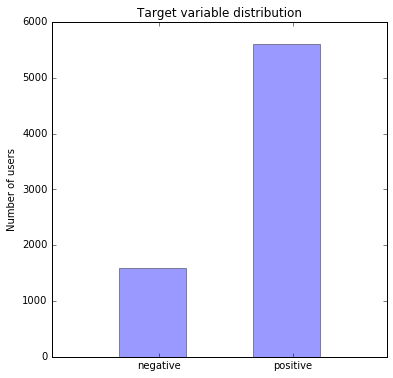

In [6]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [7]:
CONSUMER_KEY = "jpmvSIjdWwZ5EK6h0Bsq4Bmh7"
CONSUMER_SECRET = "hKCCLawMROms8S7yTmi4wakmdjaBIMQON9FOdXu0uSczetuNt6"

ACCESS_TOKEN_KEY = "288346150-0VadQaY0EEIU9kSr4TLx49nQkf1tQcPNQbc5KM6X"
ACCESS_TOKEN_SECRET = "G6tvI1c7Hq35shEFXCQjBrLLAtbHfV5wwHGtozcD73onS"

api = twitter.Api(consumer_key=CONSUMER_KEY,
                  consumer_secret=CONSUMER_SECRET,
                  access_token_key=ACCESS_TOKEN_KEY,
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [8]:
GEO_USER_NAME = "ekrivenkov"

coordinates_by_location = {}

def get_coordinates_by_location(location):
    global coordinates_by_location

    if not location in coordinates_by_location.keys():
        url = "http://api.geonames.org/searchJSON"
        params = {'q' : location, 'maxRows' : 1, 'username' : GEO_USER_NAME}
        request = requests.get(url, params = params)
        location_geonames = json.loads(request.text)['geonames'].pop()

        try:
            coordinates_by_location[location] = (location_geonames['lat'], 
                                                 location_geonames['lng'],
                                                 location_geonames['countryName'])
        except:
            coordinates_by_location[location] = None
    
    return coordinates_by_location[location]

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [9]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records_file = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records_file.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records_file:
    processed_users.add(r["uid"])

f = open(tmp_file_name, 'a')

def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,
        "created_at": dt.strftime("%Y-%m") if dt else dt,
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }

    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description

    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        coords = get_coordinates_by_location(user.location)
        if coords is not None:
            record["lat"], record["lon"], record["country"] = coords

    return record


def get_user_records(df):
    MAX_QUERY_SIZE = 100

    global f, processed_users

    list = df['uid'].tolist()
    users_to_process = len(list)
    q_list = []
    record_list = []

    for uid in list:
        if not uid in processed_users:
            if len(q_list) < MAX_QUERY_SIZE:
                q_list.append(uid)
                users_to_process -= 1
            if len(q_list) == MAX_QUERY_SIZE or users_to_process == 0:
                try:
                    users = api.UsersLookup(q_list)
                    for u in users:
                        record = twitter_user_to_dataframe_record(u)
                        json.dump(record, f)
                        f.write('\n')
                        record_list.append(record)
                except:
                    pass
                del q_list[:]
    return record_list

user_records = user_records_file + get_user_records(df_users)

f.close()
  
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records,
                          columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon",
                                   "country", "created_at", "followers_count", "friends_count", "statuses_count",
                                   "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

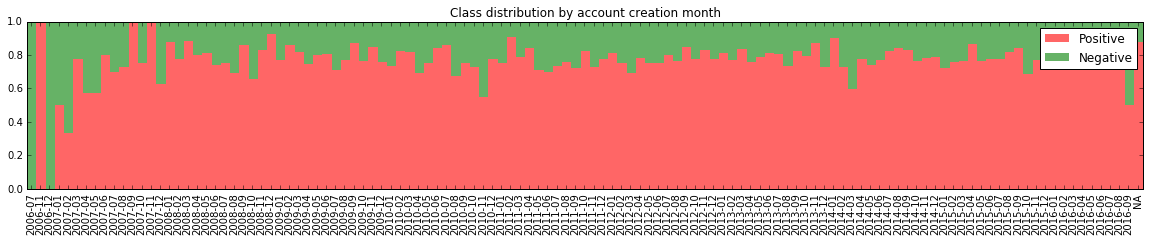

In [10]:
def count_users(grouped):
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    
    i = 0

    for name, group in grouped:
        dts.insert(i, name)
        count_pos[i] = np.count_nonzero(group.cls == 1.0)
        count_neg[i] = np.count_nonzero(group.cls == 0.0)

        i += 1

    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

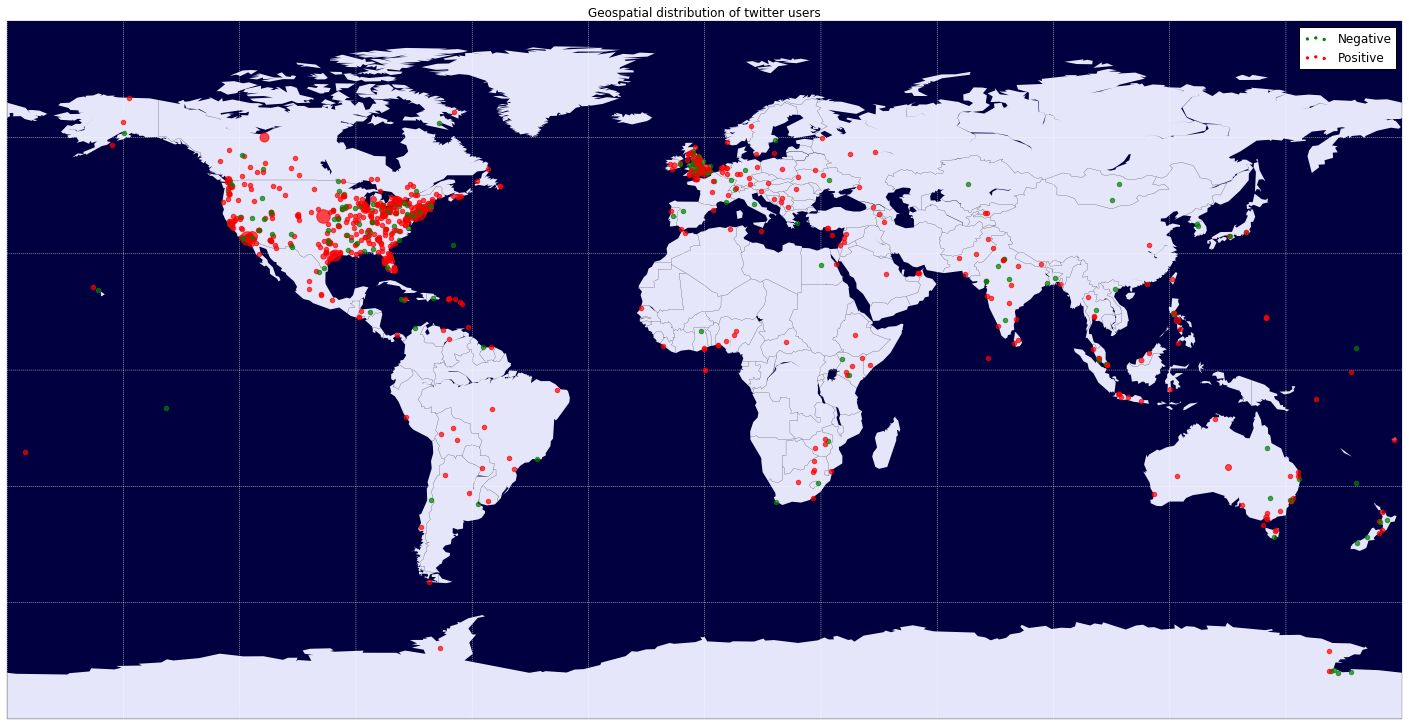

In [11]:
pl.figure(figsize=(25,15))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
    
    users_wth_neg_class = df_full[df_full["cls"]==0]
    users_wth_pos_class = df_full[df_full["cls"]==1]

    neg_notnan = users_wth_neg_class[users_wth_neg_class["lat"] == users_wth_neg_class["lat"]]
    pos_notnan = users_wth_pos_class[users_wth_pos_class["lat"] == users_wth_pos_class["lat"]]
    
    neg_grouped = neg_notnan.groupby([neg_notnan["lon"], neg_notnan["lat"]])
    pos_grouped = pos_notnan.groupby([pos_notnan["lon"], pos_notnan["lat"]])
    
    neg_dict = (neg_grouped.size()).to_dict()
    pos_dict = (pos_grouped.size()).to_dict()
    
    coords_set = set(neg_dict.keys()).union(set(pos_dict.keys()))
    for coord in coords_set:
        if not (coord in neg_dict.keys()):
            cl = 'red'
            sz = max(20, 2*pos_dict[coord])
        elif not (coord in pos_dict.keys()):
            cl = 'green'
            sz = max(20, 2*neg_dict[coord])
        else:
            if pos_dict[coord] > neg_dict[coord]:
                cl = 'red'
            else:
                cl = 'green'
            sz = max(20, 2*(neg_dict[coord] + pos_dict[coord]))
            
        m.scatter(coord[0], coord[1], s = sz, color = cl, 
              alpha = 0.7, zorder = 100)
        
    m.scatter(0, 0, color = 'green', alpha = 1, label = 'Negative', s = 5)
    m.scatter(0, 0, color = 'red', alpha = 1, label = 'Positive', s = 5)

    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Добавлен параметр прозрачности, таким образом в некоторых местах(например, в Англии) заметно, что в них перемешаны разные классы. Параметр alpha = 0.7 не мешает восприятию отдельных точек и позволяет заметить этот эффект пересечения разных цветов.
* Цвет для каждой пары координат был выбран в зависимости от того, пользователей какого класса больше в этой локации. Это звучит нечестным, так как пользователей двух классов не равное количество, но это намного удобнее для восприятия в виде карты, чем отрисовка множества кругов, которые закрывают друг друга. Теперь можно посмотреть на точку и сразу понять, пользователей какого класса в ней больше.
* Размер каждого круга теперь зависит от количества пользователей, находящихся в этом месте. Это сделано для того, чтобы по карте понимать, в каком месте находится больше пользователей. Радиус каждого круга расчитывается по формуле max(20, 2n), где n - количество пользователей из этого места. Число 20 было выбрано из-за того, что круги меньшего радиуса хуже воспринимаются глазом, а число 2 (2n) для того, чтобы большие круги были заметны, но при этом не накрывали собой огромную территорию.

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения?
           Причина проста - в mean большой вклад вносят популярные пользователи, однако их достаточно мало.
           Только у ~10% пользователей количество подписчиков больше, чем среднее.
           В median все решают "средние" пользователи и пользователи, у которых совсем мало подписчиков.
           Это типичный пример распределения, в котором есть достаточно много выбросов, которые сильно смещают
           среднее.
           Такую же ситуацию можно видеть, например, в случае с зарплатами, когда слишком большие зарплаты некоторых
           людей сильно меняют общую картину, что можно видеть, например, в государственной медицине.
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
           В целом немного популярнее пользователи отрицательного класса. Второй набор дескриптивных статистик
           (сделанных по всей выборке, без выбора случайных пользователей) показывает, что среднее и медиана у
           отрицательных пользователей больше.
           В сравнении выборок одинакового размера происходит примерное то же самое. Конечно, поскольку пользователи
           выбираются случайно, то нельзя гарантировать, что так случается постоянно, но общая тенденция такова.
           По гистограммам и данным второго набора (а именно величину max) заметно, что почти всегда первый столбец 
           у отрицательных пользователей больше, чем у положительных, а с остальными столбцами обычно все наоборот.              Значение общего максимума для положительных пользователей намного больше, чем для отрицательных.
           Отсюда получается следующий вывод: в выборке положительных пользователей немного больше очень популярных
           людей, в связи с чем разница медианы и среднего меньше, чем у отрицательных, у которых немного больше
           "средних" пользователей.
           
           
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

Запустил функцию с разными аргументами, так как интересно было посмотреть на всех положительных пользователей вместе с отрицательными.

        median, mean, max
Negative: 385 2759 490108
Positive: 351 2016 93715

Portion of users, who have more followers than mean user:
Negative: 0.094000
Positive: 0.152000


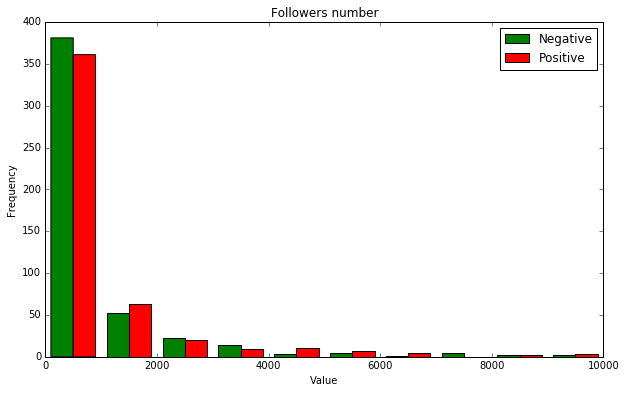

        median, mean, max
Negative: 370 3005 590515
Positive: 356 2754 1319647

Portion of users, who have more followers than mean user:
Negative: 0.098052
Positive: 0.108951


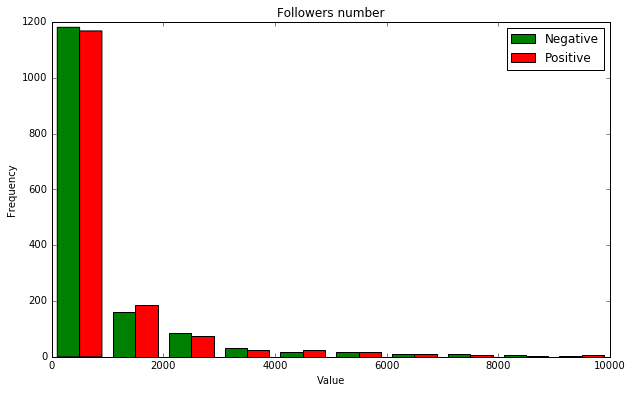

In [12]:
def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
    print '        median, mean, max'
    print 'Negative: %d %d %d' % (users_wth_neg_class["followers_count"].median(),
                                     users_wth_neg_class["followers_count"].mean(),
                                     users_wth_neg_class["followers_count"].max())
    print 'Positive: %d %d %d' % (users_wth_pos_class["followers_count"].median(),
                                     users_wth_pos_class["followers_count"].mean(),
                                     users_wth_pos_class["followers_count"].max())
    
    print '\nPortion of users, who have more followers than mean user:'
    port_neg = float(len(users_wth_neg_class[users_wth_neg_class["followers_count"] > users_wth_neg_class["followers_count"].mean()]))/float(len(users_wth_neg_class))    
    port_pos = float(len(users_wth_pos_class[users_wth_pos_class["followers_count"] > users_wth_pos_class["followers_count"].mean()]))/float(len(users_wth_pos_class))
    print 'Negative: %f' % port_neg
    print 'Positive: %f' % port_pos
    
    users_wth_pos_class = users_wth_pos_class.sample(len(users_wth_neg_class))
    
    pl.figure(figsize=(10, 6))
    pl.hist([users_wth_neg_class["followers_count"], users_wth_pos_class["followers_count"]], 
            fill = True, range = (0, 10000), color = ['green', 'red'], label = ['Negative', 'Positive'])

    pl.xlabel('Value')
    pl.ylabel('Frequency')
    pl.title('Followers number')
    pl.legend()
    pl.show()

    return

sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)

descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class)
descriptive_stat_and_hist(df_full[df_full["cls"]==0], df_full[df_full["cls"]==1])


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [13]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1052.0,1960.0,9477.0,21301.0,28.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.5486,103.5269,Malaysia,2013-04,1187.0,834.0,19267.0,7171.0,108.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,635.0,576.0,7838.0,1139.0,27.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,NaN,NaN,NaN,2013-06,2360.0,2433.0,187968.0,87862.0,68.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Awareness.Advocacy.Ascend🎈 •Focused on buildi...,False,God is my refuge; gem❤️,NaN,NaN,NaN,2015-12,1245.0,958.0,36316.0,26684.0,75.0
